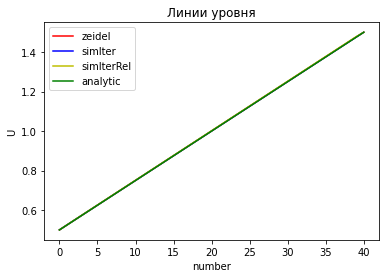

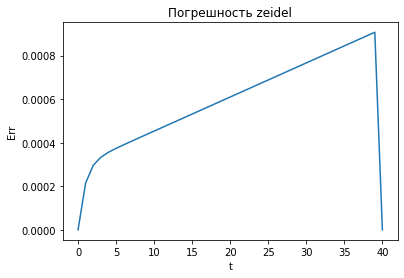

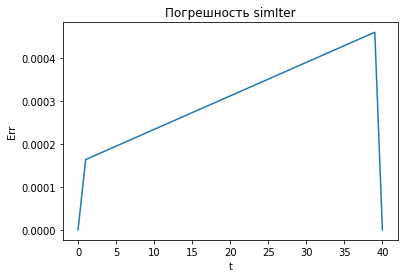

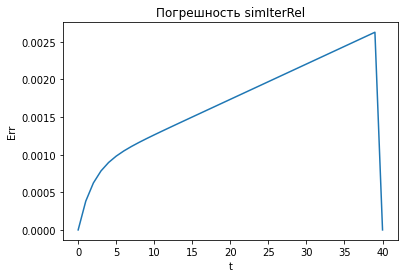

In [8]:
import copy
import numpy as np
import matplotlib.pyplot as plt

def diff(L, u, nx, ny):
    mx = 0
    for i in range(nx):
        for j in range(ny):
            mx = max(mx, abs(u[i][j] - L[i][j]))
    return mx


class Data:
    def __init__(self, args):
        self.a = args['a']
        self.b = args['b']
        self.c = args['c']
        self.d = args['d']
        self.lx = args['lx']
        self.ly = args['ly']
        self.w = args['w']
        self.f = args['f']
        self.alpha1 = args['alpha1']
        self.alpha2 = args['alpha2']
        self.beta1 = args['beta1']
        self.beta2 = args['beta2']
        self.gamma1 = args['gamma1']
        self.gamma2 = args['gamma2']
        self.delta1 = args['delta1']
        self.delta2 = args['delta2']
        self.phi1 = args['phi1']
        self.phi2 = args['phi2']
        self.phi3 = args['phi3']
        self.phi4 = args['phi4']
        self.solution = args['solution']


class ElepticalSolver:
    def __init__(self, args, nx, ny):
        self.data = Data(args)
        self.hx = self.data.lx / nx
        self.hy = self.data.ly / ny
        self.x = np.arange(0, self.data.lx + self.hx, self.hx)
        self.y = np.arange(0, self.data.ly + self.hy, self.hy)

        self.u = self.initalizeU(self.x, self.y)
        for i in range(1, nx):
            for j in range(1, ny):
                self.u[i][j] = self.u[0][j] + (self.x[i] - self.x[0]) * (self.u[-1][j] - self.u[0][j]) / (self.x[-1] - self.x[0])
        self.iteration = 0
        self.eps = 1e-6


    def initalizeU(self, x, y):
        u = np.zeros((len(x), len(y)))
        for i in range(len(x)):
            u[i][0] = self.data.phi3(x[i]) / self.data.gamma2
            u[i][-1] = self.data.phi4(x[i]) / self.data.delta2
        for j in range(len(y)):
            u[0][j] = self.data.phi1(y[j]) / self.data.alpha2
            u[-1][j] = self.data.phi2(y[j]) / self.data.beta2

        return u

    def analyticSolve(self, nx, ny):
        self.hx = self.data.lx / nx
        self.hy = self.data.ly / ny
        x = np.arange(0, self.data.lx + self.hx, self.hx)
        y = np.arange(0, self.data.ly + self.hy, self.hy)
        u = []
        for yi in y:
            u.append([self.data.solution(xi, yi) for xi in x])
        return u

    def simpleIterationMethod_solver(self, nx, ny):
        cur_eps = 1e9
        while self.iteration < 10000:
            L = copy.deepcopy(self.u)
            u = self.initalizeU(self.x, self.y)
            for j in range(1, len(self.y) - 1):
                for i in range(1, len(self.x) - 1):
                    u[i][j] = (self.hx * self.hx * self.data.f(self.x[i], self.y[j]) -
                               (L[i + 1][j] + L[i - 1][j]) - self.data.d * self.hx * self.hx *
                               (L[i][j + 1] + L[i][j - 1]) /
                               (self.hy * self.hy) - self.data.a * self.hx * 0.5 *
                               (L[i + 1][j] - L[i - 1][j]) - self.data.b * self.hx * self.hx *
                               (L[i][j + 1] - L[i][j - 1]) /
                               (2 * self.hy)) / (self.data.c * self.hx * self.hx - 2 *
                                                 (self.hy * self.hy + self.data.d * self.hx * self.hx) /
                                                 (self.hy * self.hy))
            last_eps = cur_eps
            cur_eps = diff(L, u, nx, ny)
            if diff(L, u, nx, ny) <= self.eps or last_eps < cur_eps:
                break
            self.iteration += 1
        return u, self.iteration

    def zeidelMethod_solver(self, nx, ny):
        cur_eps = 1e9
        while self.iteration < 10000:
            L = copy.deepcopy(self.u)
            u = self.initalizeU(self.x, self.y)
            for j in range(1, len(self.y) - 1):
                for i in range(1, len(self.x) - 1):
                    u[i][j] = ((self.hx ** 2) * self.data.f(self.x[i], self.y[j]) -
                               (L[i + 1][j] + u[i - 1][j]) - self.data.d * (self.hx ** 2) *
                               (L[i][j + 1] + u[i][j - 1]) / (self.hy ** 2) - self.data.a * self.hx * 0.5 *
                               (L[i + 1][j] - u[i - 1][j]) - self.data.b * (self.hx ** 2) *
                               (L[i][j + 1] - u[i][j - 1]) /
                               (2 * self.hy)) / \
                              (self.data.c * (self.hx ** 2) - 2 * (self.hy ** 2 + self.data.d * (self.hx ** 2)) /
                               (self.hy ** 2))
            last_eps = cur_eps
            cur_eps = diff(L, u, nx, ny)
            if cur_eps <= self.eps or last_eps < cur_eps:
                break
            self.iteration += 1
        return u, self.iteration

    def simpleIterationMethodRelaxed_solver(self, nx, ny):
        cur_eps = 1e9
        while self.iteration < 10000:
            L = copy.deepcopy(self.u)
            u = self.initalizeU(self.x, self.y)
            for j in range(1, len(self.y) - 1):
                for i in range(1, len(self.x) - 1):
                    u[i][j] = (((self.hx ** 2) * self.data.f(self.x[i], self.y[j]) -
                                (L[i + 1][j] + u[i - 1][j]) - self.data.d * (self.hx ** 2) *
                                (L[i][j + 1] + u[i][j - 1]) / (self.hy ** 2) - self.data.a * self.hx * 0.5 *
                                (L[i + 1][j] - u[i - 1][j]) - self.data.b * (self.hx ** 2) *
                                (L[i][j + 1] - u[i][j - 1]) /
                                (2 * self.hy)) / (self.data.c * (self.hx ** 2) - 2 *
                                                  (self.hy ** 2 + self.data.d * (self.hx ** 2)) /
                                                  (self.hy ** 2))) * self.data.w + (1 - self.data.w) * L[i][j]
            last_eps = cur_eps
            cur_eps = diff(L, u, nx, ny)
            if diff(L, u, nx, ny) <= self.eps or last_eps < cur_eps:
                break
            self.iteration += 1
        return u, self.iteration


def compareError(a, b):
    err = 0
    lst = [abs(i - j) for i, j in zip(a, b)]
    for each in lst:
        err = max(err, each)
    return err

def presontation(dict_, time=0):
    fig = plt.figure()
    plt.title('Линии уровня')
    plt.plot(dict_['zeidel'][time], color='r', label='zeidel')
    plt.plot(dict_['simIter'][time], color='b', label='simIter')
    plt.plot(dict_['simIterRel'][time], color='y', label='simIterRel')
    plt.plot(dict_['analytic'][time], color='g', label='analytic')
    plt.legend(loc='best')
    plt.ylabel('U')
    plt.xlabel('number')
    plt.show()
    
    plt.title('Погрешность zeidel')
    plt.plot(abs(dict_['zeidel'][time] - dict_['analytic'][time]))
    plt.ylabel('Err')
    plt.xlabel('t')
    plt.show()

    plt.title('Погрешность simIter')
    plt.plot(abs(dict_['simIter'][time] - dict_['analytic'][time]))
    plt.ylabel('Err')
    plt.xlabel('t')
    plt.show()

    plt.title('Погрешность simIterRel')
    plt.plot(abs(dict_['simIterRel'][time] - dict_['analytic'][time]))
    plt.ylabel('Err')
    plt.xlabel('t')
    plt.show()


if __name__ == '__main__':
    data = {'nx': 40, 'ny': 40}
    nx, ny = int(data['nx']), int(data['ny'])
    args = {
        'a': 0,
        'b': 0,
        'c': 2,
        'd': 1,
        'lx': 1,
        'ly': 1,
        'w': 1.5,
        'f': lambda x, y: 0,
        'alpha1': 0,
        'alpha2': 1,
        'beta1': 0,
        'beta2': 1,
        'gamma1': 0,
        'gamma2': 1,
        'delta1': 0,
        'delta2': 1,
        'phi1': lambda y: y,
        'phi2': lambda y: 1 + y,
        'phi3': lambda x: x,
        'phi4': lambda x: 1 + x,
        'solution': lambda x, y: x + y
    }

    analSolver = ElepticalSolver(args, nx, ny)
    simIterSolver = ElepticalSolver(args, nx, ny)
    zeidelSolver = ElepticalSolver(args, nx, ny)
    simIterRelSolver = ElepticalSolver(args, nx, ny)

    ans = {
        'analytic': analSolver.analyticSolve(nx, ny),
        'simIter': simIterSolver.simpleIterationMethod_solver(nx, ny)[0],
        'zeidel': zeidelSolver.zeidelMethod_solver(nx, ny)[0],
        'simIterRel': simIterRelSolver.simpleIterationMethodRelaxed_solver(nx, ny)[0]
    }

    presontation(ans, 20)